In [2]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima
from scipy.stats import norm

# Custom transformer import
from custom_modules.custom_transformers import TimeSeriesTransformer

In [4]:
pd.options.display.max_columns = None
%matplotlib inline
sns.set(style="darkgrid")
random_seed = 42

In [5]:
columns = ['Datetime_UTC', 'Demand_m3', 'Data_status']
df = pd.read_csv('../data/Water_usage_minute_2010_2020.txt', names=columns, header=None, delimiter='|')
df.head()

,Datetime_UTC,Demand_m3,Data_status
0,2009-12-31T23:00:00.000000Z,5872.591797,0
1,2009-12-31T23:01:00.000000Z,5864.009766,0
2,2009-12-31T23:02:00.000000Z,5855.428223,0
3,2009-12-31T23:03:00.000000Z,5846.846191,0
4,2009-12-31T23:04:00.000000Z,5838.264648,0


In [6]:
df['Datetime_UTC'] = df['Datetime_UTC'].apply(lambda x: datetime.fromisoformat(x.replace("Z", "+00:00")))
df.head()

,Datetime_UTC,Demand_m3,Data_status
0,2009-12-31 23:00:00+00:00,5872.591797,0
1,2009-12-31 23:01:00+00:00,5864.009766,0
2,2009-12-31 23:02:00+00:00,5855.428223,0
3,2009-12-31 23:03:00+00:00,5846.846191,0
4,2009-12-31 23:04:00+00:00,5838.264648,0


In [7]:
data = df.copy()
data['Datetime_UTC'] = pd.to_datetime(data['Datetime_UTC'], unit='ms')
data = data.loc[data.Datetime_UTC.between('2010-01-01', '2020-08-31')]
data.set_index('Datetime_UTC', inplace=True)
data = data.resample('d').sum()/60
#data.index = data.index.date
data = data.fillna(0)
data.head()

,Demand_m3,Data_status
Datetime_UTC,,
2010-01-01 00:00:00+00:00,168366.988411,0.0
2010-01-02 00:00:00+00:00,169425.485075,0.0
2010-01-03 00:00:00+00:00,176486.602049,0.0
2010-01-04 00:00:00+00:00,182879.800460,0.0
2010-01-05 00:00:00+00:00,179537.108252,0.0


In [8]:
def ts_analysis_plots(data, n_lags):  
    
    # AD Fuller test and linear trend of the time series
    trend, coefs = TimeSeriesTransformer.get_trend(data)
    a, b = coefs[0], coefs[1]
    adf = adfuller(data)
    
    fig, axs = plt.subplots(2, 2, figsize=(16, 8))
    axs = axs.flat

    # combine original timeseries with trendline
    df = pd.concat([data, trend], axis=1)

    # calculate a 12 period rolling mean
    df['rolling_mean'] = data.rolling(12, min_periods=1).mean()

    # calculate a 12 period rolling standard deviation
    df['rolling_std'] = data.rolling(12, min_periods=1).std()

    # plot dataframe columns against time
    sns.lineplot(data=df, ax=axs[0])
    axs[0].set(xlabel=data.index.name, ylabel=data.name, 
               title=f"Timeseries plot of data (ADF p-value: {round(adf[1], 6)}) \n \
                    (Trend: a={round(coefs[0], 2)}, b={round(coefs[1], 2)})")
        
    # histogram of value distribution
    sns.distplot(data, bins=20, hist=True, kde=True, rug=False, fit=norm, ax=axs[1],
                kde_kws={"label": "KDE"})
    axs[1].set(xlabel=data.name, ylabel="probability", title="Distribution of dataset")
    
    # autocorrelation function
    plot_acf(data, lags=n_lags, ax=axs[2])
    axs[2].set(xlabel="lag", ylabel="ACF value")
    
    # partial autocorrelation function
    plot_pacf(data, lags=n_lags, ax=axs[3])
    axs[3].set(xlabel="lag", ylabel="PACF value")
    
    plt.tight_layout()
    plt.show()

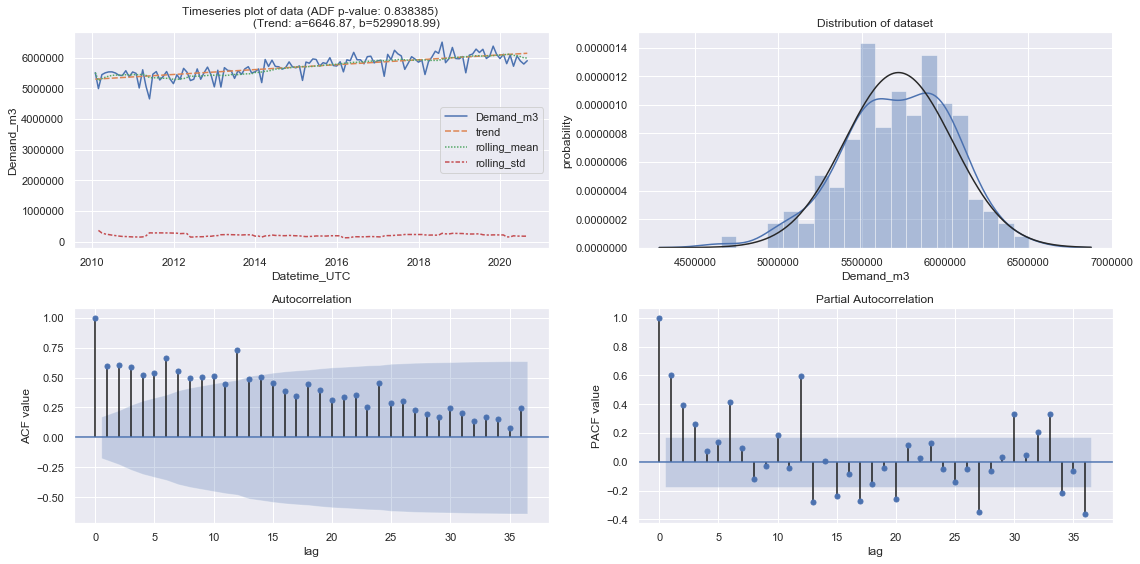

ADF Statistic: -0.731633
p-value: 0.838385
Critical Values:
	1%: -3.489
	5%: -2.887
	10%: -2.580


In [9]:
y = data.resample('M').sum()['Demand_m3']

# Generate plots and calculate ADF values
ts_analysis_plots(y, 36)

# check if dataframe is stationary
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

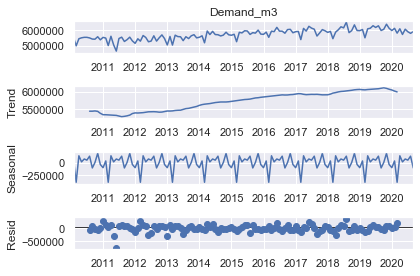

In [10]:
result = seasonal_decompose(y, model='additive', freq=12)
result.plot()

plt.show()

In [11]:
data['year'] = data.index.year
data['week_no'] = pd.Series(data.index.date).apply(lambda x: x.isocalendar()[1]).tolist()
data['day_of_yr'] = pd.Series(data.index.date).apply(lambda x: x.timetuple().tm_yday).tolist()
data.head()

,Demand_m3,Data_status,year,week_no,day_of_yr
Datetime_UTC,,,,,
2010-01-01 00:00:00+00:00,168366.988411,0.0,2010,53,1
2010-01-02 00:00:00+00:00,169425.485075,0.0,2010,53,2
2010-01-03 00:00:00+00:00,176486.602049,0.0,2010,53,3
2010-01-04 00:00:00+00:00,182879.800460,0.0,2010,1,4
2010-01-05 00:00:00+00:00,179537.108252,0.0,2010,1,5


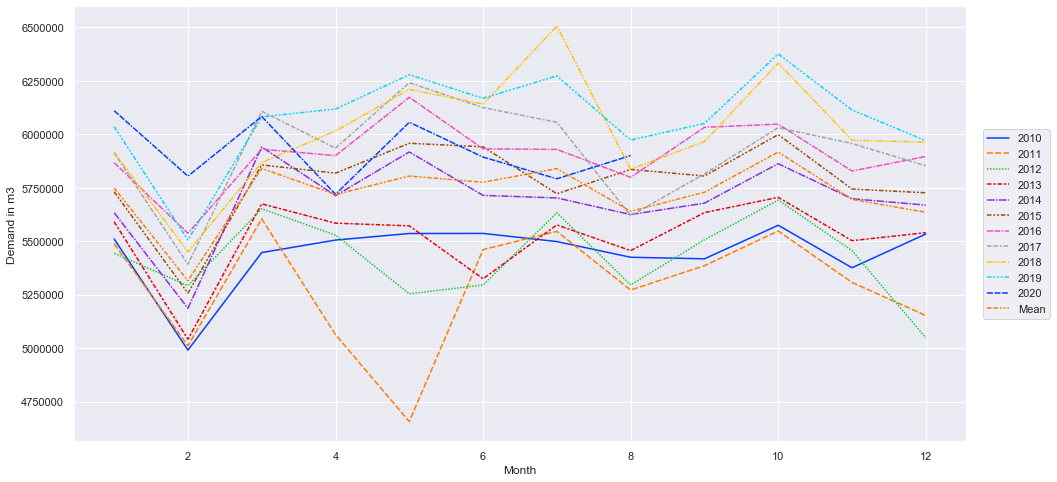

In [12]:
# Plot yearly seasonal trend
df2 = pd.pivot_table(data, index=data.index.month, columns=data.year, values='Demand_m3', aggfunc=np.sum)
df2['Mean'] = df2.mean(axis=1)

fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df2, ax=ax, palette='bright')
ax.set(xlabel='Month', ylabel='Demand in m3')

# Put a legend to the right side
plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()

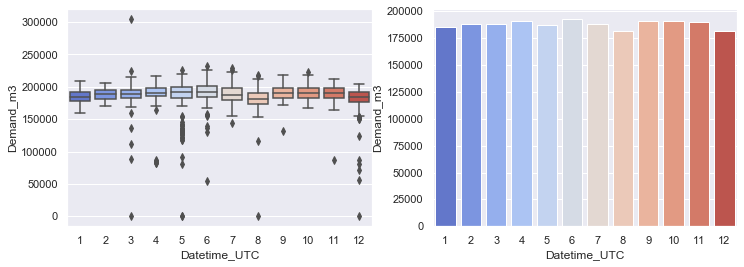

In [13]:
df_monthly = data.copy()
df_monthly.index = df_monthly.index.month
df_averages = df_monthly.groupby(df_monthly.index).mean()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs = axs.flat

sns.boxplot(x=df_monthly.index, y="Demand_m3", palette="coolwarm", data=df_monthly, ax=axs[0])
sns.barplot(x=df_averages.index, y="Demand_m3", palette="coolwarm", data=df_averages, ax=axs[1])

#plt.tight_layout()
plt.show()

In [14]:
df_yearly = data.groupby(data.index.year).sum()['Demand_m3']
df_yearly

Datetime_UTC
2010    6.535232e+07
2011    6.349633e+07
2012    6.509852e+07
2013    6.620267e+07
2014    6.834208e+07
2015    6.939674e+07
2016    7.087534e+07
2017    7.104664e+07
2018    7.217971e+07
2019    7.294843e+07
2020    4.736135e+07
Name: Demand_m3, dtype: float64

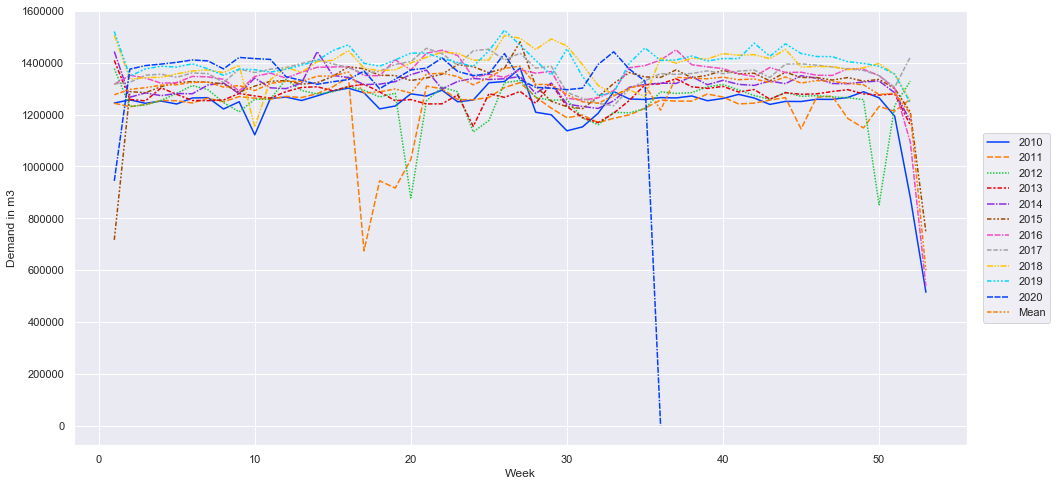

In [15]:
# Plot weekly seasonal trend
df3 = pd.pivot_table(data, index=data.week_no, columns=data.year, values='Demand_m3', aggfunc=np.sum)
df3['Mean'] = df3.mean(axis=1)

fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df3, ax=ax, palette='bright')
ax.set(xlabel='Week', ylabel='Demand in m3')

# Put a legend to the right side
plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()

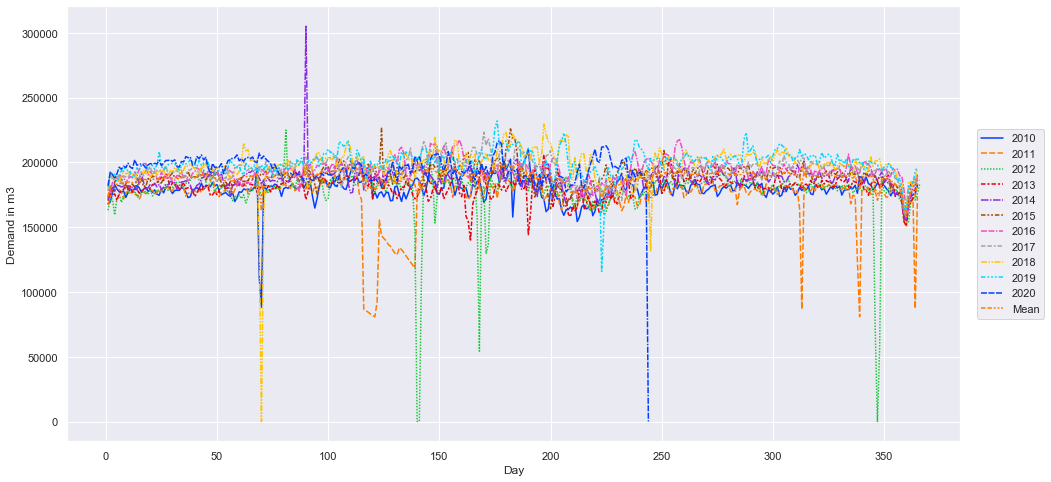

In [16]:
# Plot daily seasonal trend
df4 = pd.pivot_table(data, index=data.day_of_yr, columns=data.year, values='Demand_m3', aggfunc=np.sum)
df4['Mean'] = df4.mean(axis=1)

fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df4, ax=ax, palette='bright')
ax.set(xlabel='Day', ylabel='Demand in m3')

# Put a legend to the right side
plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()

In [17]:
def trim_outliers(df, value, grouper, q1=0.25, q3=0.75, iqr=1.5):
    # Function to filter outliers iteratively, based on boxplots and IQR
    n = 1
    
    while n > 0:
        df_grouped = df.groupby(df[grouper])[value]
        Q1 = df_grouped.quantile(q1)
        Q3 = df_grouped.quantile(q3)
        IQR = iqr * (Q3 - Q1)

        df = df.drop('min_whis', axis=1, errors='ignore').join((Q1 - IQR).rolling(3, min_periods=1).mean().rename(\
            'min_whis'), on='day_of_yr') 
        df = df.drop('max_whis', axis=1, errors='ignore').join((Q3 + IQR).rolling(3, min_periods=1).mean().rename(\
            'max_whis'), on='day_of_yr') 

        n = sum((df[value] < df['min_whis']) | (df[value] > df['max_whis']))
        print('number of outliers to trim: {}'.format(n))

        df[value].mask( (df[value] < df['min_whis']) | (df[value] > df['max_whis']), inplace=True)
    return df

In [18]:
df_daily = trim_outliers(data, 'Demand_m3', 'day_of_yr')
df_daily['Demand_m3'].interpolate(method='linear', inplace=True)
df_daily

number of outliers to trim: 85
number of outliers to trim: 14
number of outliers to trim: 9
number of outliers to trim: 2
number of outliers to trim: 5
number of outliers to trim: 3
number of outliers to trim: 5
number of outliers to trim: 5
number of outliers to trim: 2
number of outliers to trim: 2
number of outliers to trim: 2
number of outliers to trim: 0


,Demand_m3,Data_status,year,week_no,day_of_yr,min_whis,max_whis
Datetime_UTC,,,,,,,
2010-01-01 00:00:00+00:00,168366.988411,0.0,2010,53,1,155212.462475,193136.905554
2010-01-02 00:00:00+00:00,169425.485075,0.0,2010,53,2,152377.936939,204052.241388
2010-01-03 00:00:00+00:00,176486.602049,0.0,2010,53,3,154553.823249,204724.696414
2010-01-04 00:00:00+00:00,182879.800460,0.0,2010,1,4,157241.514917,207909.637444
2010-01-05 00:00:00+00:00,179537.108252,0.0,2010,1,5,162850.245029,203516.517291
...,...,...,...,...,...,...,...
2020-08-27 00:00:00+00:00,192240.113025,0.0,2020,35,240,160305.488556,210093.542694
2020-08-28 00:00:00+00:00,191251.854043,0.0,2020,35,241,160025.153283,211458.649047
2020-08-29 00:00:00+00:00,187317.263845,0.0,2020,35,242,159665.421237,212111.140756


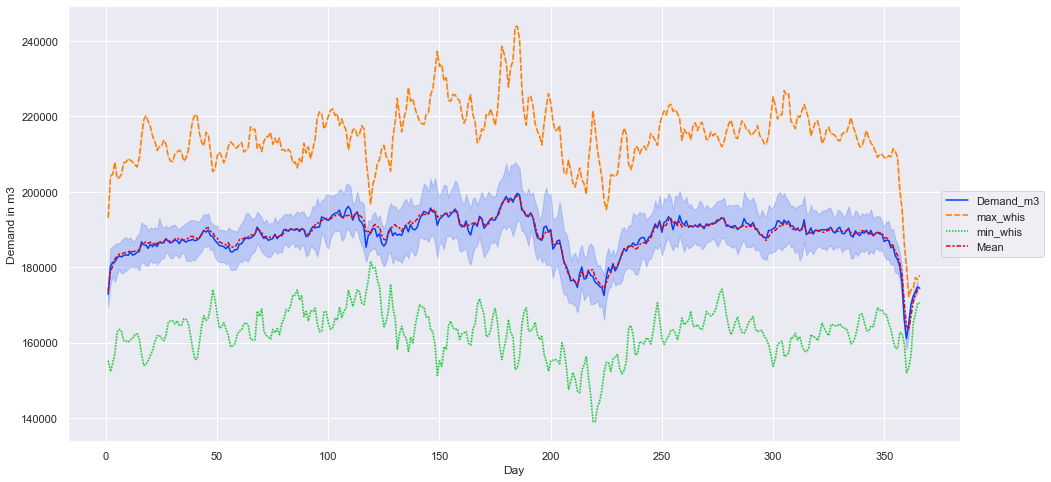

In [19]:
columns = ['Demand_m3', 'year', 'day_of_yr', 'min_whis', 'max_whis']
df5 = pd.pivot_table(df_daily[columns].loc[df_daily.year < 2020], index='day_of_yr', columns='year', aggfunc=np.sum)
df5['Mean'] = df5.mean(axis=1)

fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df5, ax=ax, palette='bright')
ax.set(xlabel='Day', ylabel='Demand in m3')

# Put a legend to the right side
plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()

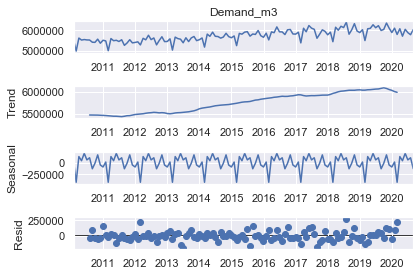

In [20]:
y = df_daily.resample('M').sum()['Demand_m3']
result = seasonal_decompose(y, model='additive', freq=12)
result.plot()

plt.show()

In [21]:
df_trf = df_daily.resample('M').sum().copy()

# Setting train and test sets
train, test = df_trf.loc['2010-1-1':'2018-12-31'], df_trf.loc['2019-1-1'::]
print(train.shape, test.shape)

# initialize a transformer class
TT = TimeSeriesTransformer(log=False, detrend=True, diff=True, scale=False)

# detrend and perform differencing on both 1 and 12 periods
train['trf_demand'] = TT.fit_transform(train.index, train.Demand_m3, [1])

##TODO check and add 1, 12 period differencing

train.head(15)

(108, 7) (20, 7)


,Demand_m3,Data_status,year,week_no,day_of_yr,min_whis,max_whis,trf_demand
Datetime_UTC,,,,,,,,
2010-01-31 00:00:00+00:00,5.510467e+06,0.0,62310,229,496,4.962244e+06,6.500629e+06,NaN
2010-02-28 00:00:00+00:00,4.990807e+06,0.0,56280,182,1274,4.589597e+06,5.936882e+06,-526220.592594
2010-03-31 00:00:00+00:00,5.628360e+06,0.0,62310,333,2325,5.144231e+06,6.572957e+06,630991.312871
2010-04-30 00:00:00+00:00,5.530608e+06,0.0,60300,452,3165,5.085372e+06,6.451240e+06,-104312.393256
2010-05-31 00:00:00+00:00,5.555788e+06,0.0,62310,602,4216,5.116663e+06,6.806570e+06,18618.961922
2010-06-30 00:00:00+00:00,5.536639e+06,0.0,60300,714,4995,4.903193e+06,6.703356e+06,-25710.273383
2010-07-31 00:00:00+00:00,5.533176e+06,0.0,62310,872,6107,4.888137e+06,6.797002e+06,-10022.954585
2010-08-31 00:00:00+00:00,5.425033e+06,0.0,62310,1010,7068,4.760727e+06,6.450063e+06,-114704.707801
2010-09-30 00:00:00+00:00,5.417805e+06,0.0,60300,1108,7755,4.931662e+06,6.516671e+06,-13788.471282


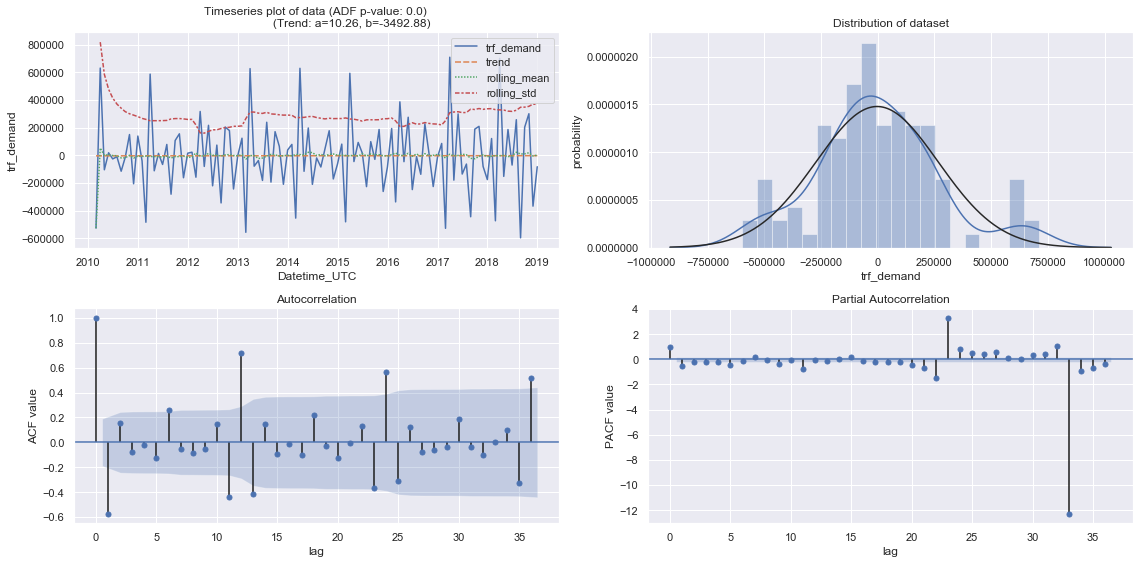

ADF Statistic: -0.738702
p-value: 0.836469
Critical Values:
	1%: -3.489
	5%: -2.887
	10%: -2.580


In [22]:
y_train = train['trf_demand'][1::]
y_test = test['Demand_m3']

# Generate plots and calculate ADF values
ts_analysis_plots(y_train, 36)

# check if dataframe is stationary
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

In [23]:
# optimizing hyper parameters
sarima_model = auto_arima(y_train, start_p=1, start_q=1,
                          max_p=12, max_q=3,
                          seasonal=True, m=12,
                          max_d=3, trace=True, random_state=42,
                          out_of_sample_size=0,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
sarima_model.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=2483.470, Time=0.61 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2536.024, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2506.295, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2480.265, Time=0.13 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2534.732, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=2493.141, Time=0.03 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=2482.012, Time=0.19 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=2482.206, Time=0.46 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=2482.136, Time=0.10 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=2522.000, Time=0.08 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=2481.750, Time=0.20 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=2486.747, Time=0.28 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=2500.289, Time=0.11 sec
 ARIMA(1,0,2)(0,1,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  107
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1234.687
Date:                            Sat, 05 Dec 2020   AIC                           2475.374
Time:                                    16:13:01   BIC                           2483.036
Sample:                                         0   HQIC                          2478.470
                                            - 107                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8231      0.101     -8.136      0.000      -1.021      -0.625
ma.S.L12      -0.5262      0.151     -3.481      0.000      -0.823      -0.230
sigma2      1.515e+10   1.99e-12   7.61e+21      0.000    1.51e+10    1.51e+10
===================================================================================
Ljung-Box (Q):                       27.67   Jarque-Bera (JB):                 7.42
Prob(Q):                              0.93   Prob(JB):                         0.02
Heteroskedasticity (H):               1.26   Skew:                             0.08
Prob(H) (two-sided):                  0.52   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.11e+37. Standard errors may be unstable.
"""

In [24]:
# (0, 0, 1)x(0, 1, 1, 12) seems to be the best option
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=(0, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                mle_regression=True,
                                enforce_stationarity=True,
                                enforce_invertibility=True)
results = mod.fit()
print(results.summary())#.tables[1])

                                     SARIMAX Results                                      
Dep. Variable:                         trf_demand   No. Observations:                  107
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1234.687
Date:                            Sat, 05 Dec 2020   AIC                           2475.374
Time:                                    16:13:01   BIC                           2483.036
Sample:                                02-28-2010   HQIC                          2478.470
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8231      0.101     -8.136      0.000      -1.021      -0.625
ma.S.L12      -0.5262      0.151   

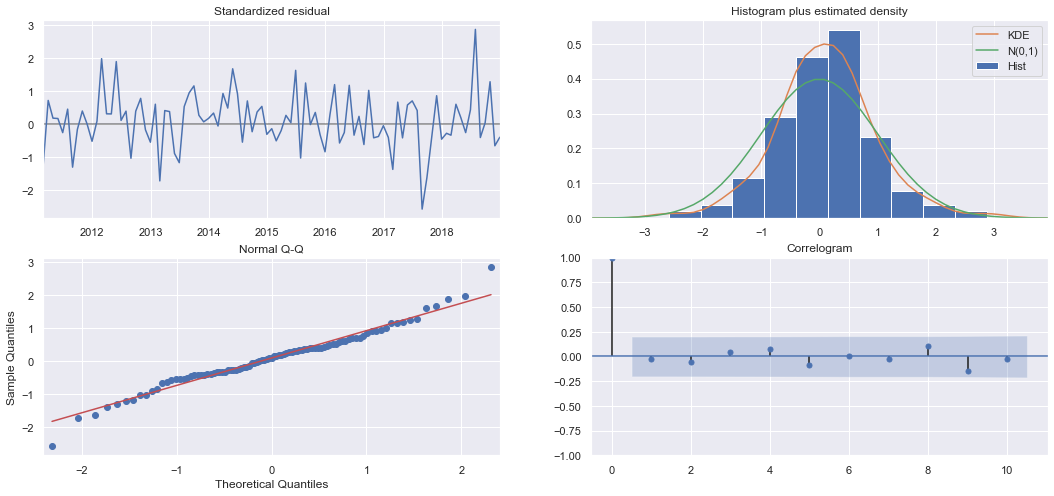

In [25]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

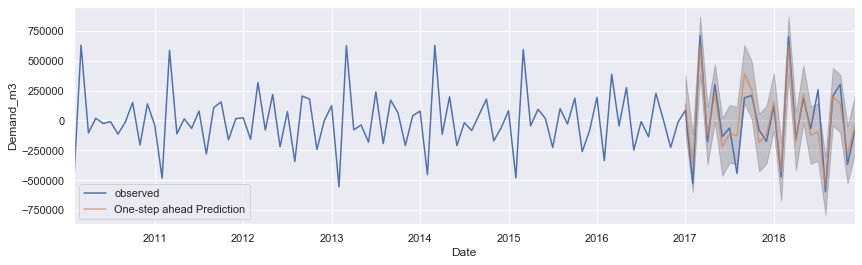

In [26]:
pred = results.get_prediction(start=datetime(2017, 1, 31).replace(tzinfo=timezone.utc), dynamic=False)

pred_ci = pred.conf_int(alpha=0.05)
ax = y_train.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Prediction', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Demand_m3')
plt.legend()
plt.show()

In [27]:
y_hat = pred.predicted_mean
y_truth = y_train['2018']
mse = ((y_hat - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 14539879327.02
The Root Mean Squared Error is 120581.42


In [28]:
pred_uc = results.get_forecast(steps=y_test.shape[0])
df_pred = pred_uc.summary_frame().rename(columns={'mean': 'y_hat', 'mean_se': 'y_hat_se'})
df_pred

trf_demand,y_hat,y_hat_se,mean_ci_lower,mean_ci_upper
2019-01-31 00:00:00+00:00,156088.928754,123074.103486,-85131.881508,397309.739016
2019-02-28 00:00:00+00:00,-466134.461815,159399.465883,-778551.674099,-153717.249530
2019-03-31 00:00:00+00:00,644037.950527,159399.465883,331620.738242,956455.162811
2019-04-30 00:00:00+00:00,-133283.413445,159399.465883,-445700.625729,179133.798840
2019-05-31 00:00:00+00:00,214541.218281,159399.465883,-97875.994003,526958.430566
2019-06-30 00:00:00+00:00,-112093.457065,159399.465883,-424510.669350,200323.755220
2019-07-31 00:00:00+00:00,94540.161658,159399.465883,-217877.050626,406957.373943
2019-08-31 00:00:00+00:00,-416459.463590,159399.465883,-728876.675875,-104042.251305
2019-09-30 00:00:00+00:00,178939.079949,159399.465883,-133478.132336,491356.292234
2019-10-31 00:00:00+00:00,219676.479994,159399.465883,-92740.732290,532093.692279


In [29]:
# join forecast with actual data
df_com = df_trf.join(train.trf_demand, how='left')
df_com = df_com.join(df_pred, how='left')
df_com.tail()

,Demand_m3,Data_status,year,week_no,day_of_yr,min_whis,max_whis,trf_demand,y_hat,y_hat_se,mean_ci_lower,mean_ci_upper
Datetime_UTC,,,,,,,,,,,,
2020-04-30 00:00:00+00:00,5.719754e+06,0.533333,60600,478,3195,5.099617e+06,6.443227e+06,NaN,-133283.413445,176382.504969,-478986.770687,212419.943798
2020-05-31 00:00:00+00:00,6.056494e+06,9.066667,62620,628,4247,5.095641e+06,6.832102e+06,NaN,214541.218281,176382.504969,-131162.138961,560244.575524
2020-06-30 00:00:00+00:00,5.893657e+06,5.133333,60600,740,5025,4.906761e+06,6.706932e+06,NaN,-112093.457065,176382.504969,-457796.814307,233609.900177
2020-07-31 00:00:00+00:00,5.792154e+06,9.133333,62620,899,6138,4.872347e+06,6.770323e+06,NaN,94540.161658,176382.504969,-251163.195584,440243.518901
2020-08-31 00:00:00+00:00,6.045133e+06,289.300000,62620,1036,7099,4.774879e+06,6.456522e+06,NaN,-416459.463590,176382.504969,-762162.820832,-70756.106348


In [30]:
# inverse detrend and differencing dataset
#df_com['y_pred'] = TT.inverse(df_com.index, df_com.y_hat.fillna(0)).values[1::]
df_com['y_pred'] = TT.start[1].append(df_com.y_hat.fillna(df_com.trf_demand + TT.trend)[1::]).cumsum()
df_com['ci_lower'] = df_com.y_pred - abs(df_com.y_hat - df_com.mean_ci_lower)
df_com['ci_upper'] = df_com.y_pred + abs(df_com.mean_ci_upper - df_com.y_hat)
df_com.loc[df_com.y_hat.isna(), ['y_pred', 'ci_lower', 'ci_upper']] = np.nan
df_com.tail()

,Demand_m3,Data_status,year,week_no,day_of_yr,min_whis,max_whis,trf_demand,y_hat,y_hat_se,mean_ci_lower,mean_ci_upper,y_pred,ci_lower,ci_upper
Datetime_UTC,,,,,,,,,,,,,,,
2020-04-30 00:00:00+00:00,5.719754e+06,0.533333,60600,478,3195,5.099617e+06,6.443227e+06,NaN,-133283.413445,176382.504969,-478986.770687,212419.943798,6.108601e+06,5.762897e+06,6.454304e+06
2020-05-31 00:00:00+00:00,6.056494e+06,9.066667,62620,628,4247,5.095641e+06,6.832102e+06,NaN,214541.218281,176382.504969,-131162.138961,560244.575524,6.323142e+06,5.977439e+06,6.668845e+06
2020-06-30 00:00:00+00:00,5.893657e+06,5.133333,60600,740,5025,4.906761e+06,6.706932e+06,NaN,-112093.457065,176382.504969,-457796.814307,233609.900177,6.211049e+06,5.865345e+06,6.556752e+06
2020-07-31 00:00:00+00:00,5.792154e+06,9.133333,62620,899,6138,4.872347e+06,6.770323e+06,NaN,94540.161658,176382.504969,-251163.195584,440243.518901,6.305589e+06,5.959885e+06,6.651292e+06
2020-08-31 00:00:00+00:00,6.045133e+06,289.300000,62620,1036,7099,4.774879e+06,6.456522e+06,NaN,-416459.463590,176382.504969,-762162.820832,-70756.106348,5.889129e+06,5.543426e+06,6.234833e+06


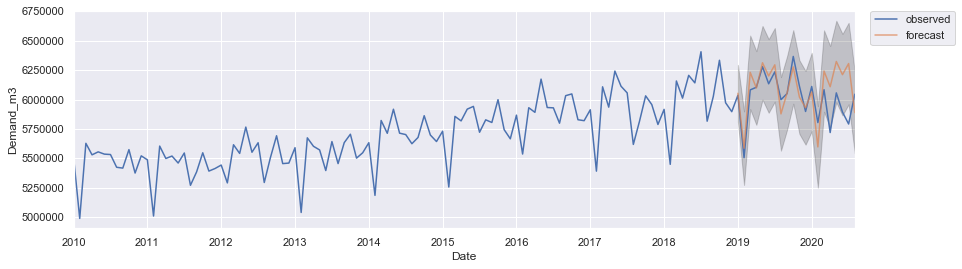

In [31]:
ax = df_com.Demand_m3.plot(label='observed')
df_com.y_pred.plot(ax=ax, label='forecast', alpha=.7, figsize=(14, 4))

ax.fill_between(df_com.index,
                df_com.ci_lower,
                df_com.ci_upper, color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Demand_m3')

plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.show()

In [32]:
actual = df_com['2019'].Demand_m3.sum()
forecast = df_com['2019'].y_pred.sum()
error = (actual - forecast) / actual

print('Actual supply in 2019: {:8.0f} m3'.format(actual))
print('Forecasted supply for 2019: {:8.0f} m3'.format(forecast))
print('Total error for 2019: {0:.4%}'.format(error))

Actual supply in 2019: 72803619 m3
Forecasted supply for 2019: 72937517 m3
Total error for 2019: -0.1839%


In [33]:
actual = df_com['2020'].Demand_m3.sum()
forecast = df_com['2020'].y_pred.sum()
error = (actual - forecast) / actual

print('Actual supply in 2020: {:8.0f}'.format(actual))
print('Forecasted supply for 2020: {:8.0f}'.format(forecast))
print('Total error for 2020: {0:.4%}'.format(error))

Actual supply in 2020: 47505804
Forecasted supply for 2020: 48741220
Total error for 2020: -2.6006%
